In [305]:
import torch
import torch.nn as nn
import os
import numpy as np
import pandas as pd
from torchvision import transforms
from torchvision import models
from collections import OrderedDict
from torch.utils import data
from PIL import Image
from torch import optim

import warnings
warnings.filterwarnings('ignore')

In [306]:
class_size = 200
root_dir = r'../input/cub2002011/CUB_200_2011'


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [307]:
class CUB_200_2011():
    def __init__(self, root_dir, dataset_type='train', train_ratio=1, validation_seed=1, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform

        img_data = pd.read_csv(os.path.join(root_dir, 'images.txt'), sep=' ', names=['ID', 'Image'], index_col=0, header=None)
        label_data = pd.read_csv(os.path.join(root_dir, 'image_class_labels.txt'), sep=' ', names=['ID', 'Label'], index_col=0, header=None)
        split_data = pd.read_csv(os.path.join(root_dir, 'train_test_split.txt'), sep=' ', names=['ID', 'Train'], index_col=0, header=None)
        Total_data = pd.concat([img_data, label_data, split_data], axis=1)
        Total_data['Label'] = Total_data['Label'] - 1
        if dataset_type == 'test':
            Total_data = Total_data[Total_data['Train'] == 0]
        elif dataset_type == 'train' or dataset_type == 'valid':
            Total_data = Total_data[Total_data['Train'] == 1]
            if train_ratio != 1:
                np.random.seed(validation_seed)
                indices = list(range(len(Total_data)))
                np.random.shuffle(indices)
                split_idx = int(len(indices) * train_ratio) + 1
            if dataset_type == 'train':
                Total_data = Total_data.iloc[indices[:split_idx]]
            else:
                Total_data = Total_data.iloc[indices[split_idx:]]
        self.img_names = Total_data['Image'].tolist()
        self.labels = Total_data['Label'].tolist()

        self._convert_to_rgb()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, 'images', self.img_names[idx])
        image = Image.open(img_path)
        target = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            target = self.target_transform(target)
        return image, target

    def _convert_to_rgb(self):
        for i, img_name in enumerate(self.img_names):
            img_path = os.path.join(self.root_dir, 'images', img_name)
            image = Image.open(img_path)
            color_mode = image.mode
            if color_mode != 'RGB':
                self.img_names[i] = img_name.replace('.jpg', '_rgb.jpg')


In [308]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1), ratio=(3/4, 4/3)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])


In [309]:
split_ratio = 0.9
random_seed = 1
train_dataset = CUB_200_2011(root_dir, 'train', split_ratio, random_seed, transform=transform_train)
valid_dataset = CUB_200_2011(root_dir, 'valid', split_ratio, random_seed, transform=transform_test)

print(f"Training Data Length: {len(train_dataset)}")
print(f"Validation Data Length: {len(valid_dataset)}")


Training Data Length: 5395
Validation Data Length: 599


In [311]:
batch_size = 64
train_dataset_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
valid_dataset_loader = data.DataLoader(valid_dataset, batch_size=batch_size*2, shuffle=False, num_workers=4)

In [312]:
model = models.densenet169(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([
    ('fc0', nn.Linear(1664, 256)),
    ('norm0', nn.BatchNorm1d(256)),
    ('relu0', nn.ReLU(inplace=True)),
    ('fc1', nn.Linear(256, class_size))
]))

model.classifier = classifier

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [313]:
criterion = nn.CrossEntropyLoss()

In [314]:
def accuracy(model, data_loader, length=None):
    test_correct = 0
    
    if length == None:
        length = len(data_loader.dataset)
    
    training = model.training
    if training:
        model.eval()
        
    with torch.no_grad():
        for input, labels in data_loader:
            input, labels = input.to(device), labels.to(device)
            output = model(input)
            _, yhat = torch.max(output.data, 1)
            test_correct = test_correct + (yhat == labels).sum().item()
    test_accuracy = test_correct / length
    
    if training:
        model.train()

    return test_accuracy

In [315]:
costs = []
epoch_train_loss = []
epoch_train_accuracies = []
test_accuracies = []

In [316]:
def train(model, train_dataset_loader, test_dataset_loader, optimizer, scheduler, max_epoch=100, test_period=10):
    length_train = len(train_dataset_loader.dataset)
    length_test = len(test_dataset_loader.dataset)
    best_accuracy = 0
    
    model.train()

    for epoch in range(max_epoch):
        cost = 0
        correct = 0
        
        for input, labels in train_dataset_loader:
            input, labels = input.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(input)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            cost += loss.item()
            _, yhat = torch.max(output.data, 1)
            correct += (yhat == labels).sum().item()
            
        costs.append(cost/len(train_loader))
        scheduler.step()

        acc = correct / length_train
        epoch_train_accuracies.append(acc)

        if epoch % test_period == 0:
            test_accuracy = accuracy(model, test_dataset_loader, length_test)
            test_accuracies.append(test_accuracy)
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
            print("{:3d} cost: {:.4f}\ttrain_accuracy: {:.4f}\ttest_accuracy: {:.4f}".format(
                epoch, cost, acc, test_accuracy))
            
    print(len(test_accuracies))
    print(len(epoch_train_accuracies))
    print('\nfinal accuracy')
    print('train: {:.3f}%\ttest: {:.3f}%\tbest on test: {:.3f}%'.format(acc*100, accuracy(model, test_dataset_loader)*100, best_accuracy*100))

In [317]:
params = {
    'learning_rate': 0.001,
    'weight_decay_rate': 0.0001,
    'max_epoch': 30,
    'test_period': 1
}

optimizer = optim.AdamW(model.classifier.parameters(), lr=params['learning_rate'], betas=(0.9, 0.999), weight_decay=params['weight_decay_rate'])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=params['max_epoch'], eta_min=0)

train(model, train_dataset_loader, valid_dataset_loader, optimizer, scheduler, params['max_epoch'], params['test_period'])


  0 cost: 373.8450	train_accuracy: 0.1425	test_accuracy: 0.3456
  1 cost: 246.2885	train_accuracy: 0.4358	test_accuracy: 0.4891
  2 cost: 179.4145	train_accuracy: 0.5672	test_accuracy: 0.5309
  3 cost: 143.3952	train_accuracy: 0.6323	test_accuracy: 0.5843
  4 cost: 118.6573	train_accuracy: 0.6851	test_accuracy: 0.5659
  5 cost: 103.2600	train_accuracy: 0.7223	test_accuracy: 0.5893
  6 cost: 91.2601	train_accuracy: 0.7509	test_accuracy: 0.5927
  7 cost: 81.7102	train_accuracy: 0.7702	test_accuracy: 0.5793
  8 cost: 74.8298	train_accuracy: 0.7885	test_accuracy: 0.5943
  9 cost: 67.5802	train_accuracy: 0.8106	test_accuracy: 0.6144
 10 cost: 62.2640	train_accuracy: 0.8243	test_accuracy: 0.5993
 11 cost: 57.4577	train_accuracy: 0.8402	test_accuracy: 0.6077
 12 cost: 53.5244	train_accuracy: 0.8471	test_accuracy: 0.6060
 22 cost: 35.0124	train_accuracy: 0.9097	test_accuracy: 0.6043
 23 cost: 31.6228	train_accuracy: 0.9192	test_accuracy: 0.5893
 24 cost: 31.5104	train_accuracy: 0.9129	test_acc

In [358]:
import matplotlib.pyplot as plt

def cost_curve(costs, title='loss vs epoch'):
    plt.figure(dpi=100)
    plt.plot(costs)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(title)
    plt.show()

def accuracy_curve(epoch_train_accuracies, test_accuracies, test_period=1, title='Accuracy vs Epoch'):
    epochs = test_period * len(test_accuracies)
#     print(epoch_train_accuracies)
#     print(test_accuracies)
    epoch_train_accuracies = epoch_train_accuracies[:epochs]
    x_axis = np.arange(1, epochs+1, test_period).astype(int)
    print(x_axis)
    plt.figure(dpi=100)
    plt.plot(x_axis, epoch_train_accuracies[::test_period], color='tab:blue', label='train accuracy')
    plt.plot(x_axis, test_accuracies, color='tab:red', label='test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('train_accuracies')
    plt.legend()
    plt.title(title)
    plt.show()


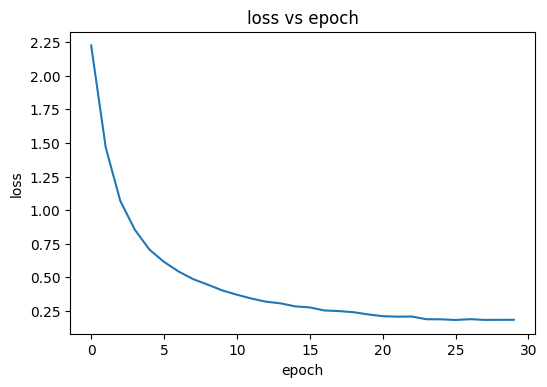

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]


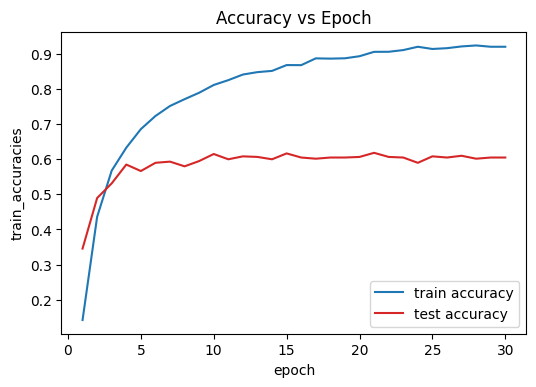

In [359]:
cost_curve(costs)
accuracy_curve(epoch_train_accuracies, test_accuracies, test_period)

In [357]:
test_data = CUB_200_2011(root_dir, 'test', split_ratio, random_seed, transform=transform_test)
test_dataset_loader = data.DataLoader(test_data, batch_size=batch_size*2, shuffle=False, num_workers=4)

test_acc = accuracy(model, test_loader, len(test_data))
print("Test Accuracy: {:.3f}%".format(test_acc * 100))

Test Accuracy: 57.818%
